In [1]:
DATASET_TYPE = 'dataset_2'
ARCHITECTURE = 'resnet'

In [2]:
import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss
from torch.optim import Adam

import torchvision
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18

import numpy as np

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import seaborn as sns


In [3]:
# splitting the dataset into specific folders for train, validate and test

import splitfolders

source_folder = f'{DATASET_TYPE}'
target_folder = f'{DATASET_TYPE}_splitted'

train_ratio = .7
val_ratio = .15
test_ratio = .15

splitfolders.ratio(source_folder, output=target_folder, seed=1337, ratio=(train_ratio, val_ratio, test_ratio), group_prefix=None, move=False)

Copying files: 14658 files [00:45, 319.95 files/s]


In [4]:
# applying data prepocessing and loading dataset
train_dataset_tranform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_dataset_tranform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = ImageFolder(f"{DATASET_TYPE}_splitted/train", transform=train_dataset_tranform)
train_length = len(train_dataset)

validate_dataset = ImageFolder(f"{DATASET_TYPE}_splitted/val", transform=test_dataset_tranform)
validate_length = len(validate_dataset)

test_dataset = ImageFolder(f"{DATASET_TYPE}_splitted/test", transform=test_dataset_tranform)
test_dataset = len(test_dataset)

dataset_classes = train_dataset.classes
print(dataset_classes)

['early blight', 'healthy', 'late blight', 'mosaic virus', 'powdery mildew', 'septoria']


In [5]:
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validate_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


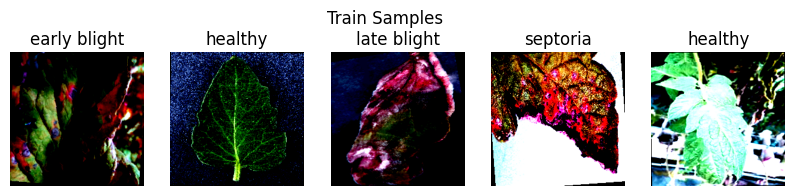

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


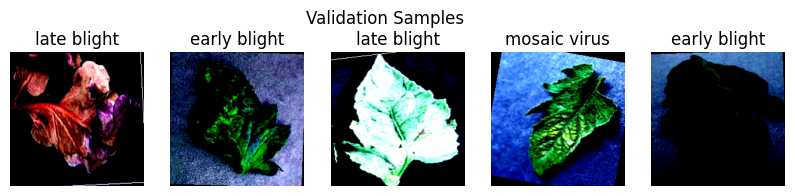

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


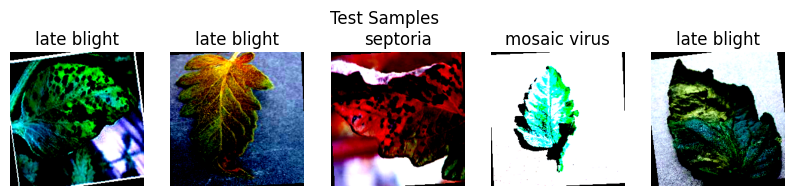

In [6]:
def show_images(loader, title):
    # Get a batch of images and labels from the loader
    images, labels = next(iter(loader))
    images = images.numpy()
    labels = labels.numpy()

    # Plot the images
    plt.figure(figsize=(10, 4))
    for i in range(5):
        plt.subplot(2, 5, i + 1)
        plt.imshow(np.transpose(images[i], (1, 2, 0)))
        plt.title(f'{dataset_classes[labels[i]]}')
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Display sample images from train loader
show_images(train_loader, 'Train Samples')

# Display sample images from validation loader
show_images(validate_loader, 'Validation Samples')

# Display sample images from test loader
show_images(test_loader, 'Test Samples')

In [7]:
# setting up the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [8]:
# modifying architecture output classes
class ResNet18(nn.Module):
  def __init__(self, num_of_classes):
    super(ResNet18, self).__init__()
    self.model = resnet18(weights=None)
    features = self.model.fc.in_features
    self.model.fc = nn.Linear(features, num_of_classes)

  def forward(self, x):
    x = self.model(x)
    return x

In [9]:
# defining model, optimizer, architecture
learning_rate = 0.001
epochs = 15

model = ResNet18(num_of_classes=len(dataset_classes))
model = model.to(device)
optimizer = Adam(model.parameters(), lr=learning_rate)
loss_function = CrossEntropyLoss()

print(model)

ResNet18(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn